## Importing Libraries

In [1]:
!pip install lion_pytorch

In [2]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torchvision
from torch.optim import *
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import transforms
import torch.nn.functional as F

from lion_pytorch import Lion

import math
import time
import numpy as np
from PIL import Image
import cv2
import numpy as np
import albumentations
import albumentations.pytorch
from matplotlib import pyplot as plt
import matplotlib.animation as animation
from matplotlib import font_manager, rc
from IPython import display
import random
import glob
import os
from os import listdir
from os.path import isfile, join
import warnings
import sys
from tqdm import tqdm
import pickle
import gc
import random
import urllib.request

warnings.filterwarnings("ignore")

print("Version of Torch : {0}".format(torch.__version__))
print("Version of TorchVision : {0}".format(torchvision.__version__))

Version of Torch : 1.13.0

Version of TorchVision : 0.14.0


In [3]:
gc.collect()
torch.cuda.empty_cache()

## Styling Parameters

In [4]:
%matplotlib inline

plt.rcParams['axes.unicode_minus'] = False
fontpath = "/kaggle/input/koreanfont/NanumGothic.ttf"
fontprop = font_manager.FontProperties(fname=fontpath)

plt.rcParams["animation.html"] = "jshtml"
plt.rcParams['figure.dpi'] = 150  
plt.ioff()

## Hyper Parameters

In [5]:
# Device
USE_CUDA = torch.cuda.is_available()   # check if GPU is available
print("Device : {0}".format("GPU" if USE_CUDA else "CPU"))   # print device type
device = torch.device("cuda" if USE_CUDA else "cpu")   # set device to GPU or CPU based on availability
cpu_device = torch.device("cpu")   # set CPU device

# Train
EPOCHS = 9   # number of training epochs
BATCH_SIZE = 32   # batch size for training
START_EPOCH = 1   # epoch to start training from

lr = 0.0001   # learning rate for optimizer

IMAGE_SIZE = 256   # size of input images
MAX_LEN = 10   # maximum length of captcha text
DATASET_PATH = [   # paths to training dataset
    "/kaggle/input/large-captcha-dataset/Large_Captcha_Dataset",
    "/kaggle/input/captcha-dataset",
    "/kaggle/input/comprasnet-captchas/comprasnet_imagensacerto",
    "/kaggle/input/captcha-images"
]

BAN_DATA = [   # paths to exclude from training dataset
    '/kaggle/input/large-captcha-dataset/Large_Captcha_Dataset/4q2wA.png',
]

RANDOM_SEED = 2004   # random seed for reproducibility

USE_CHECKPOINT = True   # whether to use checkpoint for training
CHECKPOINT_PATH = "/kaggle/input/pytorch-captcha-recognizer/Checkpoint.pth"   # path to saved checkpoint```


Device : GPU


In [6]:
def random_seed():
    torch.manual_seed(RANDOM_SEED)
    torch.cuda.manual_seed(RANDOM_SEED)
    torch.cuda.manual_seed_all(RANDOM_SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(RANDOM_SEED)
    random.seed(RANDOM_SEED)

    print('Random Seed : {0}'.format(RANDOM_SEED))
    
random_seed()

Random Seed : 2004


In [7]:
if USE_CHECKPOINT:
    checkpoint = torch.load(CHECKPOINT_PATH, map_location=device)   # load checkpoint from path specified in CHECKPOINT_PATH
    START_EPOCH = checkpoint["epoch"]+1   # set starting epoch number to epoch number in the checkpoint plus one
    print("Loading Checkpoint [START_EPOCH : {0}]".format(START_EPOCH))   # print message indicating checkpoint is being loaded
else :
    START_EPOCH = 1   # set starting epoch number to 1
    print("Training New Model")   # print message indicating new model is being trained


Loading Checkpoint [START_EPOCH : 10]


## Dataset

In [8]:
special_char_list = ["<pad>"] # special characters that can appear in captchas (in this case, just padding)
num_list = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']   # numbers that can appear in captchas
upper_alphabet_list = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']   # uppercase letters that can appear in captchas
lower_alphabet_list = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']   # lowercase letters that can appear in captchas

string_list = special_char_list + num_list + upper_alphabet_list + lower_alphabet_list   # list of all characters that can appear in captchas
CHAR_NUM = len(string_list)   # total number of characters that can appear in captchas

token_dictionary = {i : string_list[i] for i in range(len(string_list))}   # dictionary that maps token indices to their corresponding characters
reversed_token_dictionary = {v: k for k, v in token_dictionary.items()}   # dictionary that maps characters to their corresponding token indices

print(CHAR_NUM)   # print number of characters in the list (including padding)```


63


In [9]:
def torch_tensor_to_plt(img):
    img = img.detach().numpy()[0]   # convert tensor to numpy array and extract the first (and only) channel
    img = np.transpose(img, (1, 2, 0))   # rearrange dimensions from (channel, height, width) to (height, width, channel)
    return img   # return the rearranged numpy array```


In [10]:
transformer = transforms.Compose([
    transforms.ToTensor(),   # Convert the input image from PIL Image format to PyTorch tensor
    torchvision.transforms.Resize((IMAGE_SIZE,IMAGE_SIZE)),   # Resize the input image to the specified dimensions
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),   # Normalize the pixel values of the input image
])

This is a PyTorch Dataset class that loads image and text data and returns it in a format that can be fed to the model.

def __init__(self, path, transform=None): : This function initializes the dataset by taking in the path to the data and the data transformer function. It creates a list of image files, self.file, by reading all files in the specified path with .png or .jpg extensions. It also removes any files in BAN_DATA from the list. It then initializes self.num to the length of self.file.

def __len__(self): : This function returns the number of files in self.file.

def transform(self, image): : This function applies the transform function specified in the initialization to the image.

def __getitem__(self, idx): : This function returns a single instance of the data with the image and corresponding text label as tensors. It takes in an index, idx, and gets the filename at that index from self.file. It then converts the characters in the filename to corresponding integer values using reversed_token_dictionary and pads it with <pad> to MAX_LEN length. It reads the image using cv2.imread(), converts it to a sketch image using cv2.cvtColor(), applies the transform function to it, and returns the image tensor and the text label tensor.

In [11]:
class ImageToTextDataset(Dataset):
    def __init__(self, path, transform=None):
        self.path = path
        self.transformer = transform
        self.file = []
        
        file_list = glob.glob(join(self.path, '*'))
        self.file = [file for file in file_list if (file.endswith(".png") or file.endswith(".jpg"))]
        
        for ban_file in BAN_DATA:
            if ban_file in self.file:
                self.file.remove(ban_file)
        
        self.num = len(self.file)
        
    def __len__(self):
        return self.num
    
    def transform(self, image):
        if self.transformer!=None:
            return self.transformer(image)
        else :
            return image

    def __getitem__(self, idx):
        filename = self.file[idx]
        
        Y = []
        for char in list(filename.split("/")[-1].split(".")[0]):
            Y.append(reversed_token_dictionary[char])
            
        if len(Y) < MAX_LEN:
            Y += [reversed_token_dictionary["<pad>"]]*(MAX_LEN-len(Y))
        
        img = cv2.imread(self.file[idx])
        try:
            sketch_image = cv2.cvtColor(img[:,:256,:], cv2.COLOR_BGR2RGB)
        except:
            print(self.file[idx])
        X = self.transform(sketch_image)
        
        Y_tensor_list = []
        for y_ind in Y:
            y_tensor = torch.zeros(CHAR_NUM)
            y_tensor[y_ind] = 1
            Y_tensor_list.append(y_tensor.unsqueeze(0))

        return X, torch.tensor(Y), torch.tensor(Y) #torch.cat(Y_tensor_list).transpose(-1, -2), torch.tensor(Y)

In [12]:
# create an empty list to hold the dataset objects
dataset_list = []

# iterate over each path in DATASET_PATH
for dataset_path in DATASET_PATH:
    # create an ImageToTextDataset object with the corresponding path and transformer
    dataset_list.append(ImageToTextDataset(dataset_path, transform=transformer))

# concatenate the datasets
dataset = torch.utils.data.ConcatDataset(dataset_list)

# split the dataset into train and test sets
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [len(dataset)-len(dataset)//10, len(dataset)//10])

# create dataloaders for the train and test sets
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

# print the train-test ratio and the total number of train and test images
print("Train Test Ratio : {0}:{1}".format(len(dataset)-len(dataset)//10, len(dataset)//10))
print("Total Train Images : {0}".format(len(train_dataset)))
print("Total Test Images : {0}".format(len(test_dataset)))


데이터 비율 : 244263:27140

학습 데이터 양 : 244263

검증 데이터 양 : 27140


torch.Size([3, 256, 256])


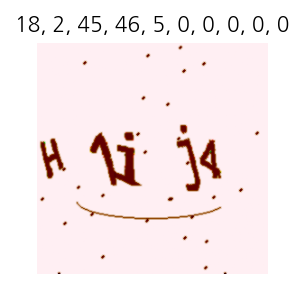

In [13]:
x_val, _, target = dataset[0]
print(x_val.shape)
fig = plt.figure(figsize=(2, 2))
plt.imshow(torch_tensor_to_plt(x_val.unsqueeze(0)), cmap='gray')
plt.axis('off')
plt.title(', '.join(map(str, target.tolist())), fontproperties=fontprop)
plt.show()

## Model - LACC 
LACC stands for Label Combination Classifier, and it is a deep learning model used for image-to-text translation tasks. In this particular code snippet, the LACC model is defined as a PyTorch neural network using the EfficientNetV2-S backbone architecture for feature extraction from the input images.

After the feature extraction process, the extracted features are flattened and multiplied by a trainable parameter matrix, the converter, which combines the feature information into a smaller representation suitable for text prediction. The converted features are then passed through three fully connected layers, each followed by a SiLU activation function, to predict the final text output.

The output of the LACC model is a tensor of shape (batch_size, max_length), where max_length is the maximum length of the predicted text, and each element in the tensor represents a probability distribution over the set of possible characters at the corresponding position in the predicted text.

The LACC class defines a PyTorch module that represents the Label Combination Classifier. It consists of an EfficientNetV2_S model as the encoder and several fully-connected layers that map encoded image features to character embeddings. The forward method performs a forward pass of an input image tensor through the encoder, followed by the fully-connected layers, to obtain the predicted character embeddings.

In [14]:
class LACC(nn.Module):
    def __init__(self):
        super().__init__()
        
        # Use the EfficientNetV2_S model from torchvision as encoder
        self.encoder = torchvision.models.efficientnet_v2_s().features
        
        # Define the converter parameter which maps encoded features to character embeddings
        self.converter = nn.parameter.Parameter(torch.ones(64, CHAR_NUM))        
        
        # Use SiLU (Sigmoid-Weighted Linear Unit) activation function
        self.silu = nn.SiLU()
        
        # Define fully-connected layers
        self.linear1 = nn.Linear(1280, 512)
        self.linear2 = nn.Linear(512, 64)
        self.linear3 = nn.Linear(64, MAX_LEN)
        

    def forward(self, x):
        # Pass the input image tensor through the encoder
        feature = self.encoder(x)
        
        # Flatten the feature tensor along dimensions 2 and 3
        feature = torch.flatten(feature, start_dim=2)
        
        # Apply the converter to the flattened feature tensor to obtain character embeddings
        feature = torch.matmul(feature, self.converter)
        
        # Transpose the character embeddings tensor
        y = feature.transpose(-1, -2)
        
        # Pass the transposed tensor through the fully-connected layers, using SiLU activation function in between
        y = self.linear1(y)
        y = self.silu(y)
        y = self.linear2(y)
        y = self.silu(y)
        y = self.linear3(y)
        
        return y


In [15]:
model = LACC().to(device)

## Train

In [16]:
optimizer = Lion(model.parameters(), lr=lr, weight_decay=1e-2)
criterion = nn.CrossEntropyLoss()

In [17]:
def calculate_loss(predict, y):
    return criterion(predict, y)

In [18]:
def getSimilar(list1, list2):
    correct = 0  # initialize a variable to keep track of the number of correct matches
    for item1, item2 in zip(list1, list2):  # loop through the two input lists simultaneously using zip function
        if item1==item2:  # check if the two corresponding items are the same
            correct += 1  # increment correct variable if they are same
    return correct  # return the number of correct matches

def getCorrect(list1, list2):
    if ''.join(map(str,list1))==''.join(map(str,list2)):  # join the elements of list1 and list2 into strings and check if they are equal
        return 1  # if they are equal, return 1 to indicate a correct match
    else :
        return 0  # if they are not equal, return 0 to indicate a incorrect match


In [19]:
def evalSample(model, x, target, batch=0):
    # replace special tokens for display
    def replaceSpeicalToken(text):
        text = text.replace('<pad>','□')
        text = text.replace('<unk>','?')
        return text
    
    # move inputs and model to device
    x, target = x.to(device), target.to(device)
    model.eval()
    
    # get model predictions and convert to text
    predict = model(x[batch].unsqueeze(0))
    predict = F.log_softmax(predict, dim=-2)
    predict = torch.argmax(predict, dim=-2)
    predict_text = ""
    for token in predict[0].to(cpu_device).tolist():
        predict_text += str(token_dictionary[token])
    
    # convert targets to text
    target_text = ""
    for token in target[0].to(cpu_device).tolist():
        target_text += str(token_dictionary[token])
        
    # replace special tokens for display
    predict_text = replaceSpeicalToken(predict_text)
    target_text = replaceSpeicalToken(target_text)
        
    # display image and predicted/target text
    fig = plt.figure(figsize=(2, 2))
    plt.imshow(torch_tensor_to_plt(x.to(cpu_device)[batch].unsqueeze(0)), cmap='gray')
    plt.axis('off')
    plt.title(f"Answer of AI : {predict_text} [Real Answer : {target_text}]", fontproperties=fontprop)
    plt.show()
    
    # return predicted and target text
    return predict_text, target_text


In [20]:
def train_one_epoch(model, optimizer, train_dataloader, test_dataloader, epoch=None):
    # Initialize variables to keep track of loss and accuracy
    train_loss = 0.0
    test_loss = 0.0
    accurate = 0.0
    hard_accurate = 0.0
    
    # Training
    # Set model to train mode
    model.train()
    # Iterate through training dataloader
    for x, y, label_target in train_dataloader:
        # Send input and target tensors to device
        x, y = x.to(device), y.to(device)
        
        # Zero-out gradients
        model.zero_grad()
        
        # Perform forward pass through the model
        predict = model(x)
        predict = F.log_softmax(predict, dim=-2)
        predict_text = torch.argmax(predict, dim=-2)
        
        # Calculate loss
        loss = calculate_loss(predict, y)

        # Perform backward pass and optimization step
        loss.backward()
        optimizer.step()
        
        # Accumulate training loss
        train_loss += loss.item()
    # Calculate average training loss
    train_loss /= len(train_dataloader)    
    
    # Testing
    # Set model to evaluation mode
    model.eval()
    
    # Iterate through testing dataloader
    for x, y, target in test_dataloader:
        # Send input and target tensors to device
        x, y, target = x.to(device), y.to(device), target.to(device)
        
        # Perform forward pass through the model
        predict = model(x)
        predict = F.log_softmax(predict, dim=-2)
        
        # Calculate loss
        loss = calculate_loss(predict, y)
        
        # Compute prediction accuracy
        predict = torch.argmax(predict, dim=-2)
        for predict_item, y_item in zip(predict, target):
            accurate += getSimilar(predict_item, y_item)/(MAX_LEN*BATCH_SIZE)
            hard_accurate += getCorrect(predict_item, y_item)/(BATCH_SIZE)
        
        # Accumulate testing loss
        test_loss += loss.item()
        
    # Calculate average testing loss and accuracy
    test_loss /= len(test_dataloader)    
    accurate /= len(test_dataloader)
    hard_accurate /= len(test_dataloader)
    
    # Print training and testing loss and accuracy (if epoch is specified)
    if epoch != None:
        print(f"[Epoch {epoch}] Train Loss : {train_loss} & Test Loss : {test_loss} & Accurate : {accurate*100}% & Hard-Accurate : {hard_accurate*100}%")
        
    return train_loss, test_loss


In [21]:
if USE_CHECKPOINT:
    model.load_state_dict(checkpoint["model_state_dict"])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

## Training the Data

In [22]:
train_loss_list = []
test_loss_list = []

for epoch in range(START_EPOCH, START_EPOCH+EPOCHS):
    train_loss, test_loss = train_one_epoch(model, optimizer, train_dataloader, test_dataloader, epoch=epoch)
    
    train_loss_list.append(train_loss)
    test_loss_list.append(test_loss)

[Epoch 10] Train Loss : 0.07334848221120363 & Test Loss : 0.07076577884249292 & Accurate : 97.11204358068582% & Hard-Accurate : 82.30270906949352%

[Epoch 11] Train Loss : 0.07227112761573494 & Test Loss : 0.07335817845027073 & Accurate : 97.08259717314778% & Hard-Accurate : 82.1591578327444%

[Epoch 12] Train Loss : 0.08257123664696621 & Test Loss : 0.07481796289624118 & Accurate : 97.04137220259483% & Hard-Accurate : 81.78371613663134%

[Epoch 13] Train Loss : 0.7235790971208294 & Test Loss : 0.9086137175981231 & Accurate : 75.68610129564152% & Hard-Accurate : 8.532096584216726%

[Epoch 14] Train Loss : 0.12688082604985493 & Test Loss : 0.07427580560117662 & Accurate : 97.03769140165208% & Hard-Accurate : 82.09658421672556%

[Epoch 15] Train Loss : 0.08286474248764508 & Test Loss : 0.07830787839661972 & Accurate : 96.9537691401684% & Hard-Accurate : 81.1027679623086%

[Epoch 16] Train Loss : 0.0689808630088602 & Test Loss : 0.06812376710546485 & Accurate : 97.26553297997934% & Hard-A

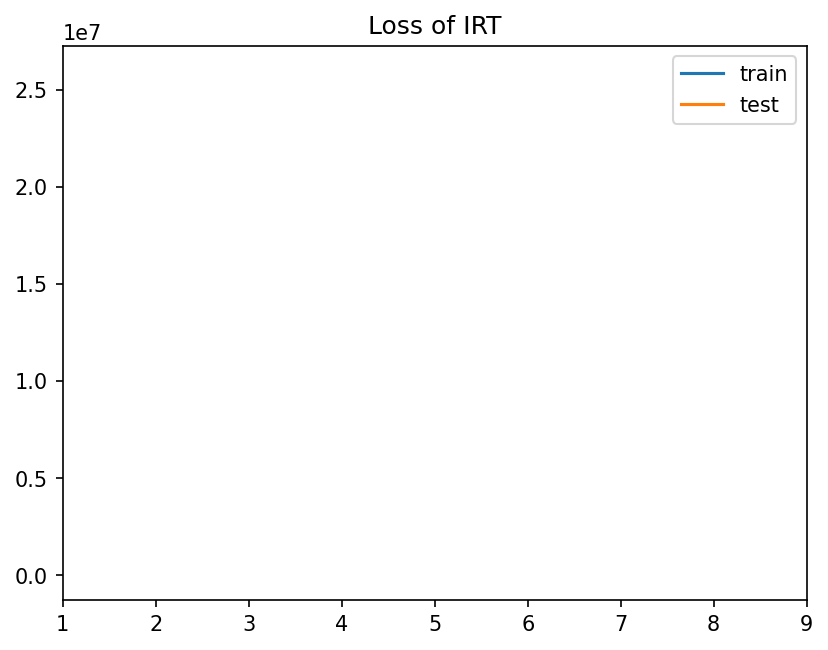

In [23]:
x = np.array(list(range(START_EPOCH, START_EPOCH+EPOCHS)))
plt.plot(x, np.array(train_loss_list),label='train')
plt.plot(x, np.array(test_loss_list),label='test')
plt.xlim([1, EPOCHS])
plt.title(f"Loss of IRT")
plt.legend(loc='upper right')
plt.show()

In [24]:
import time

## Some Examples

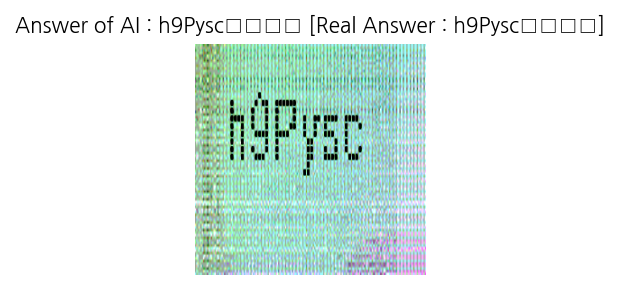

0.2752392292022705초


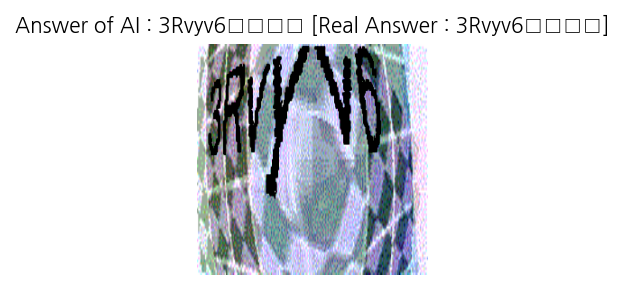

0.16640949249267578초


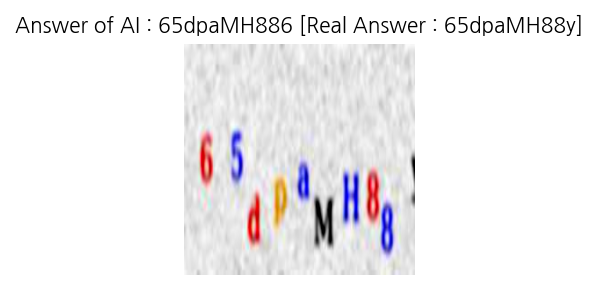

0.15448355674743652초


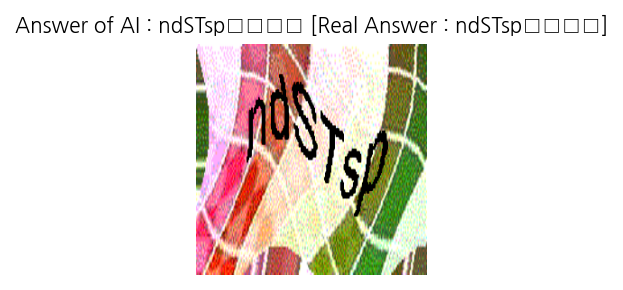

0.19010591506958008초


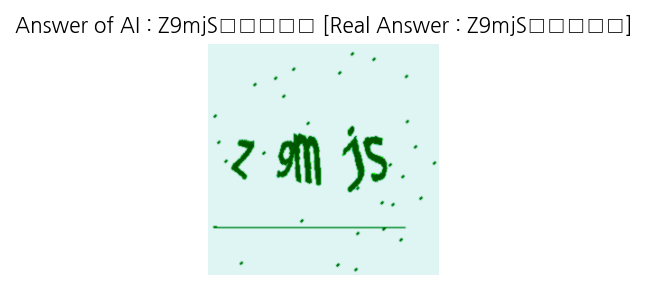

0.143218994140625초


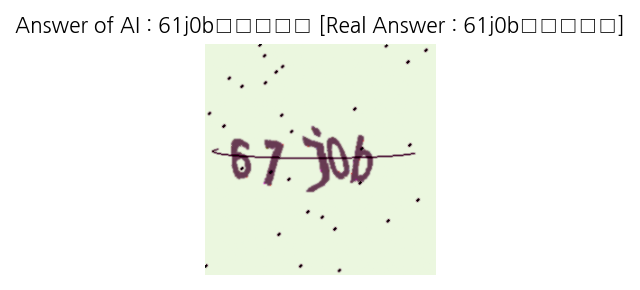

0.15331220626831055초


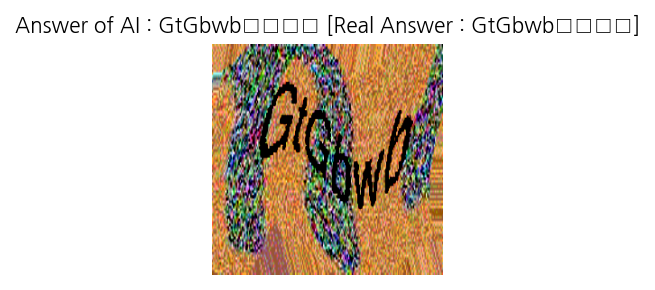

0.15844035148620605초


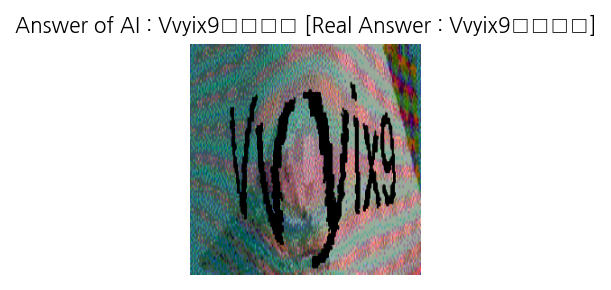

0.19087648391723633초


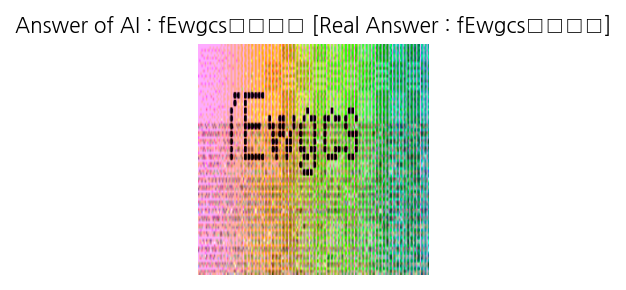

0.1896514892578125초


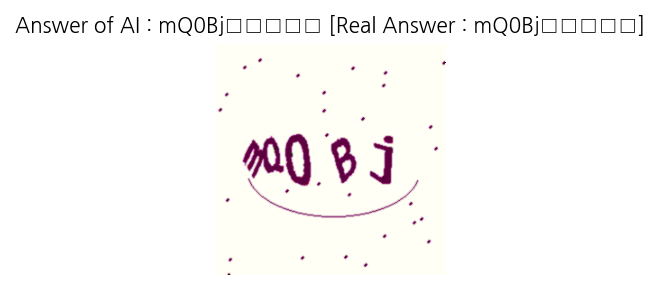

0.14108490943908691초


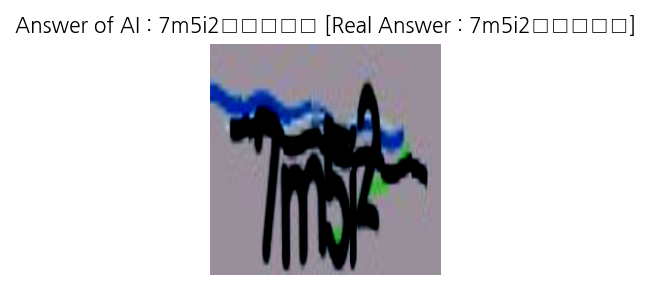

0.16584157943725586초


In [25]:
for ind, (x, _, y) in enumerate(test_dataloader):
    if ind > 10:
        break
    old_time = time.time()
    predict_text, target_text = evalSample(model, x, y)
    print(f"{time.time()-old_time}s")

## Saving the model

In [26]:
torch.save({
            'epoch': START_EPOCH+EPOCHS,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            }, 'Checkpoint.pth')